# 🧠 **Beyin Tümörü Tespiti ve Sınıflandırması**

MRI görüntülerinden beyin tümörü tespiti ve sınıflandırması için Vision Transformer (ViT) tabanlı derin öğrenme projesi.

**Sınıflar:**
- Glioma - Glial hücrelerden kaynaklanan tümör
- Meningioma - Meninks zarından kaynaklanan tümör
- Pituitary - Hipofiz bezi tümörü
- Healthy - Sağlıklı beyin

### **1. Gerekli Kütüphanelerin İçe Aktarılması**

In [2]:
import os
import cv2
import timm
import torch
import shutil
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from skimage import exposure
from datetime import datetime
import matplotlib.pyplot as plt
from torchvision import transforms
from collections import defaultdict
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support, accuracy_score)

In [3]:
# Genel Değişkenler
DATASET_PATH = "dataset"
OUTPUT_PATH = "dataset_processed"
TARGET_SIZE = (224, 224)
CLASSES = ["glioma", "healthy", "meningioma", "pituitary"]

print(f"Veriseti yolu: {DATASET_PATH}")
print(f"İşlenmiş veriseti yolu: {OUTPUT_PATH}")
print(f"Hedef boyut: {TARGET_SIZE}")
print(f"Sınıflar: {CLASSES}")

Veriseti yolu: dataset
İşlenmiş veriseti yolu: dataset_processed
Hedef boyut: (224, 224)
Sınıflar: ['glioma', 'healthy', 'meningioma', 'pituitary']


### **2. Veri Seti Analizi**

- Veri Setindeki Görsellerin Sınıf Bazlı Genişlik, Yükseklik ve Kanal Sayısı İstatiklerinin İncelenmesi 

In [4]:
# Analiz Fonksiyonu
def analyze_dataset():
    class_stats = {}
    all_images_info = []
    
    for class_name in CLASSES:
        class_path = os.path.join(DATASET_PATH, class_name)
        
        if not os.path.exists(class_path):
            print(f"UYARI: {class_path} klasörü bulunamadı!")
            continue
        
        # Görüntü dosyalarını listele
        image_files = [f for f in os.listdir(class_path) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        
        class_stats[class_name] = {
            'count': len(image_files),
            'widths': [],
            'heights': [],
            'channels': []
        }
        
        print(f"\n{class_name.upper()} sınıfı analiz ediliyor...")
        
        for img_file in tqdm(image_files, desc=f"{class_name}"):
            img_path = os.path.join(class_path, img_file)
            
            img = cv2.imread(img_path)
            
            if img is not None:
                h, w = img.shape[:2]
                channels = img.shape[2] if len(img.shape) == 3 else 1
                
                class_stats[class_name]['widths'].append(w)
                class_stats[class_name]['heights'].append(h)
                class_stats[class_name]['channels'].append(channels)
                
                all_images_info.append({
                    'class': class_name,
                    'width': w,
                    'height': h,
                    'channels': channels
                })
    
    return class_stats, all_images_info

class_stats, all_images_info = analyze_dataset()


GLIOMA sınıfı analiz ediliyor...


glioma: 100%|██████████| 3768/3768 [01:04<00:00, 58.16it/s]



HEALTHY sınıfı analiz ediliyor...


healthy: 100%|██████████| 3990/3990 [01:05<00:00, 60.57it/s]



MENINGIOMA sınıfı analiz ediliyor...


meningioma: 100%|██████████| 3806/3806 [01:04<00:00, 58.98it/s]



PITUITARY sınıfı analiz ediliyor...


pituitary: 100%|██████████| 4041/4041 [01:09<00:00, 58.46it/s]


In [5]:
# İstatistiklerin görüntülenmesi
print("\n" + "=" * 60)
print("SINIF BAZLI İSTATİSTİKLER")
print("=" * 60)

total_images = 0

for class_name, stats in class_stats.items():
    count = stats['count']
    total_images += count
    
    print(f"\n📁 {class_name.upper()} ===> Görüntü sayısı: {count}")
    
    if stats['widths']:
        print(f"   Genişlik - Min: {min(stats['widths'])}, Max: {max(stats['widths'])}, Ort: {np.mean(stats['widths']):.1f} | " + 
              f"Yükseklik - Min: {min(stats['heights'])}, Max: {max(stats['heights'])}, Ort: {np.mean(stats['heights']):.1f} | " + 
              f"Kanal sayısı: {set(stats['channels'])}")

print(f"\n{'=' * 60}")
print(f"TOPLAM GÖRÜNTÜ SAYISI: {total_images}")
print(f"{'=' * 60}")

# Sınıf dağılımı yüzdeleri
print("\n📊 SINIF DAĞILIMI:")
for class_name, stats in class_stats.items():
    percentage = (stats['count'] / total_images) * 100 if total_images > 0 else 0
    bar = "█" * int(percentage / 2)
    print(f"   {class_name:12s}: {stats['count']:4d} ({percentage:5.1f}%) {bar}")


SINIF BAZLI İSTATİSTİKLER

📁 GLIOMA ===> Görüntü sayısı: 3768
   Genişlik - Min: 512, Max: 512, Ort: 512.0 | Yükseklik - Min: 512, Max: 512, Ort: 512.0 | Kanal sayısı: {3}

📁 HEALTHY ===> Görüntü sayısı: 3990
   Genişlik - Min: 150, Max: 1920, Ort: 313.7 | Yükseklik - Min: 168, Max: 1446, Ort: 319.9 | Kanal sayısı: {3}

📁 MENINGIOMA ===> Görüntü sayısı: 3806
   Genişlik - Min: 174, Max: 1275, Ort: 486.2 | Yükseklik - Min: 195, Max: 1427, Ort: 488.7 | Kanal sayısı: {3}

📁 PITUITARY ===> Görüntü sayısı: 4041
   Genişlik - Min: 201, Max: 1365, Ort: 509.2 | Yükseklik - Min: 202, Max: 1365, Ort: 509.1 | Kanal sayısı: {3}

TOPLAM GÖRÜNTÜ SAYISI: 15605

📊 SINIF DAĞILIMI:
   glioma      : 3768 ( 24.1%) ████████████
   healthy     : 3990 ( 25.6%) ████████████
   meningioma  : 3806 ( 24.4%) ████████████
   pituitary   : 4041 ( 25.9%) ████████████


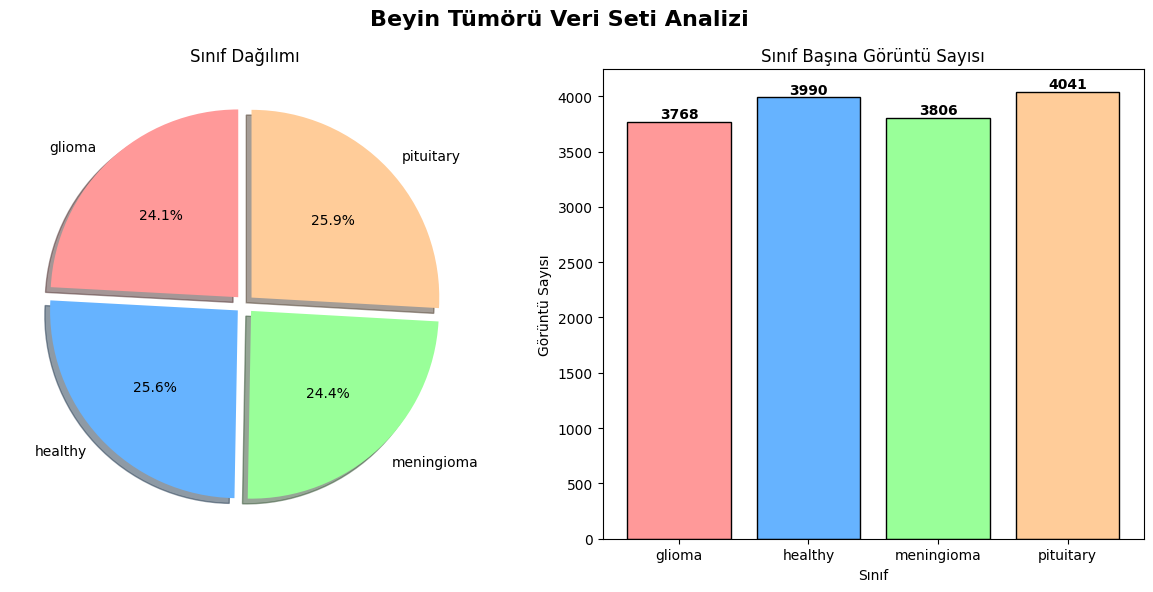

In [6]:
# Veri seti dağılım grafikleri
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Beyin Tümörü Veri Seti Analizi', fontsize=16, fontweight='bold')

# 1. Sınıf dağılımı pasta grafiği
ax1 = axes[0]
counts = [stats['count'] for stats in class_stats.values()]
labels = list(class_stats.keys())
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
explode = (0.05, 0.05, 0.05, 0.05)

ax1.pie(counts, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title('Sınıf Dağılımı')

# 2. Sınıf dağılımı bar grafiği
ax2 = axes[1]
bars = ax2.bar(labels, counts, color=colors, edgecolor='black')
ax2.set_xlabel('Sınıf')
ax2.set_ylabel('Görüntü Sayısı')
ax2.set_title('Sınıf Başına Görüntü Sayısı')
for bar, count in zip(bars, counts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

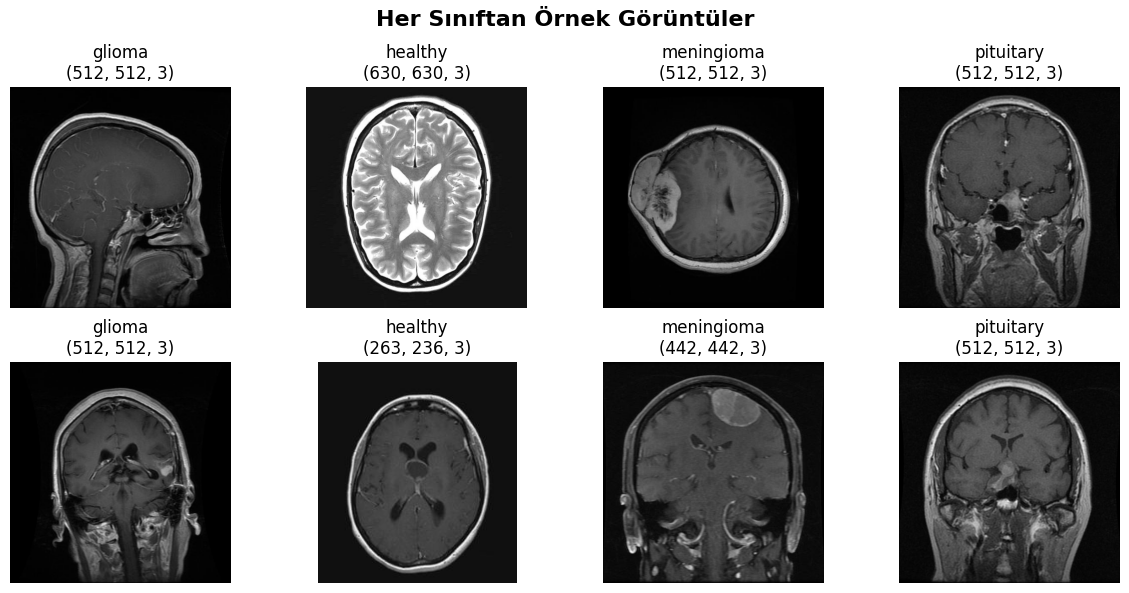

In [7]:
# Her sınıftan örnek görüntüler
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Her Sınıftan Örnek Görüntüler', fontsize=16, fontweight='bold')

for idx, class_name in enumerate(CLASSES):
    class_path = os.path.join(DATASET_PATH, class_name)
    
    if os.path.exists(class_path):
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        
        if image_files:
            # İkinci ve ortadaki görüntülerin görüntülenmesi
            img_path1 = os.path.join(class_path, image_files[1])
            img_path2 = os.path.join(class_path, image_files[len(image_files)//2])
            
            img1 = cv2.imread(img_path1)
            img2 = cv2.imread(img_path2)
            
            if img1 is not None:
                img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
                axes[0, idx].imshow(img1_rgb)
                axes[0, idx].set_title(f'{class_name}\n{img1.shape}')
                axes[0, idx].axis('off')
            
            if img2 is not None:
                img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
                axes[1, idx].imshow(img2_rgb)
                axes[1, idx].set_title(f'{class_name}\n{img2.shape}')
                axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

### **3. Görüntü Ön İşleme Pipeline**

Görüntülere uygulanacak ön işleme adımları:
- Siyah kenar kırpma
- Bilateral filtre ile gürültü giderme
- Kontrast artırma (CLAHE)
- 224x224 - Sabit boyutlandırma
- Normalizasyon

In [8]:
class ImagePreprocessor:
    """Görüntü ön işleme sınıfı"""
    
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size
    
    # Beyin dışındaki siyah alanların kırpılması fonksiyonu
    def crop_black_borders(self, image, threshold=10):
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()
        
        _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            
            margin = 5
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(image.shape[1] - x, w + 2 * margin)
            h = min(image.shape[0] - y, h + 2 * margin)
            
            cropped = image[y:y+h, x:x+w]
            return cropped
        
        return image
    
    # Gürültü giderme fonksiyonu
    def denoise(self, image, method='bilateral'):
        if method == 'gaussian':
            return cv2.GaussianBlur(image, (3, 3), 0)
        elif method == 'median':
            return cv2.medianBlur(image, 3)
        elif method == 'bilateral':
            return cv2.bilateralFilter(image, 5, 75, 75)
        return image
    
    # CLAHE ile kontrast artırma fonksiyonu
    def enhance_contrast_clahe(self, image, clip_limit=2.0, tile_grid_size=(8, 8)):
        if len(image.shape) == 3:
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
        else:
            l = image.copy()
        
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        l_enhanced = clahe.apply(l)
        
        if len(image.shape) == 3:
            enhanced_lab = cv2.merge([l_enhanced, a, b])
            enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
        else:
            enhanced = l_enhanced
        
        return enhanced
    
    # Görüntüyü yeniden boyutlandırma fonksiyonu
    def resize(self, image, size=None):
        if size is None:
            size = self.target_size
        
        h, w = image.shape[:2]
        if h > size[1] or w > size[0]:
            interp = cv2.INTER_AREA
        else:
            interp = cv2.INTER_LINEAR
        
        return cv2.resize(image, size, interpolation=interp)
    
    # Normalizasyon fonksiyonu
    def normalize(self, image, method='uint8'):
        if method == 'minmax':
            image = image.astype(np.float32)
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)
            return image
        elif method == 'uint8':
            image = image.astype(np.float32)
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)
            return (image * 255).astype(np.uint8)
        return image
    # Tam ön işleme pipeline'ı için fonksiyon
    def preprocess_pipeline(self, image, crop=True, denoise_method='bilateral',
                           enhance_contrast=True, normalize_method='uint8'):
        if crop:
            image = self.crop_black_borders(image)
        if denoise_method:
            image = self.denoise(image, method=denoise_method)
        if enhance_contrast:
            image = self.enhance_contrast_clahe(image)
        image = self.resize(image)
        if normalize_method:
            image = self.normalize(image, method=normalize_method)
        return image

preprocessor = ImagePreprocessor(target_size=TARGET_SIZE)
print("✅ ImagePreprocessor sınıfı oluşturuldu!")

✅ ImagePreprocessor sınıfı oluşturuldu!


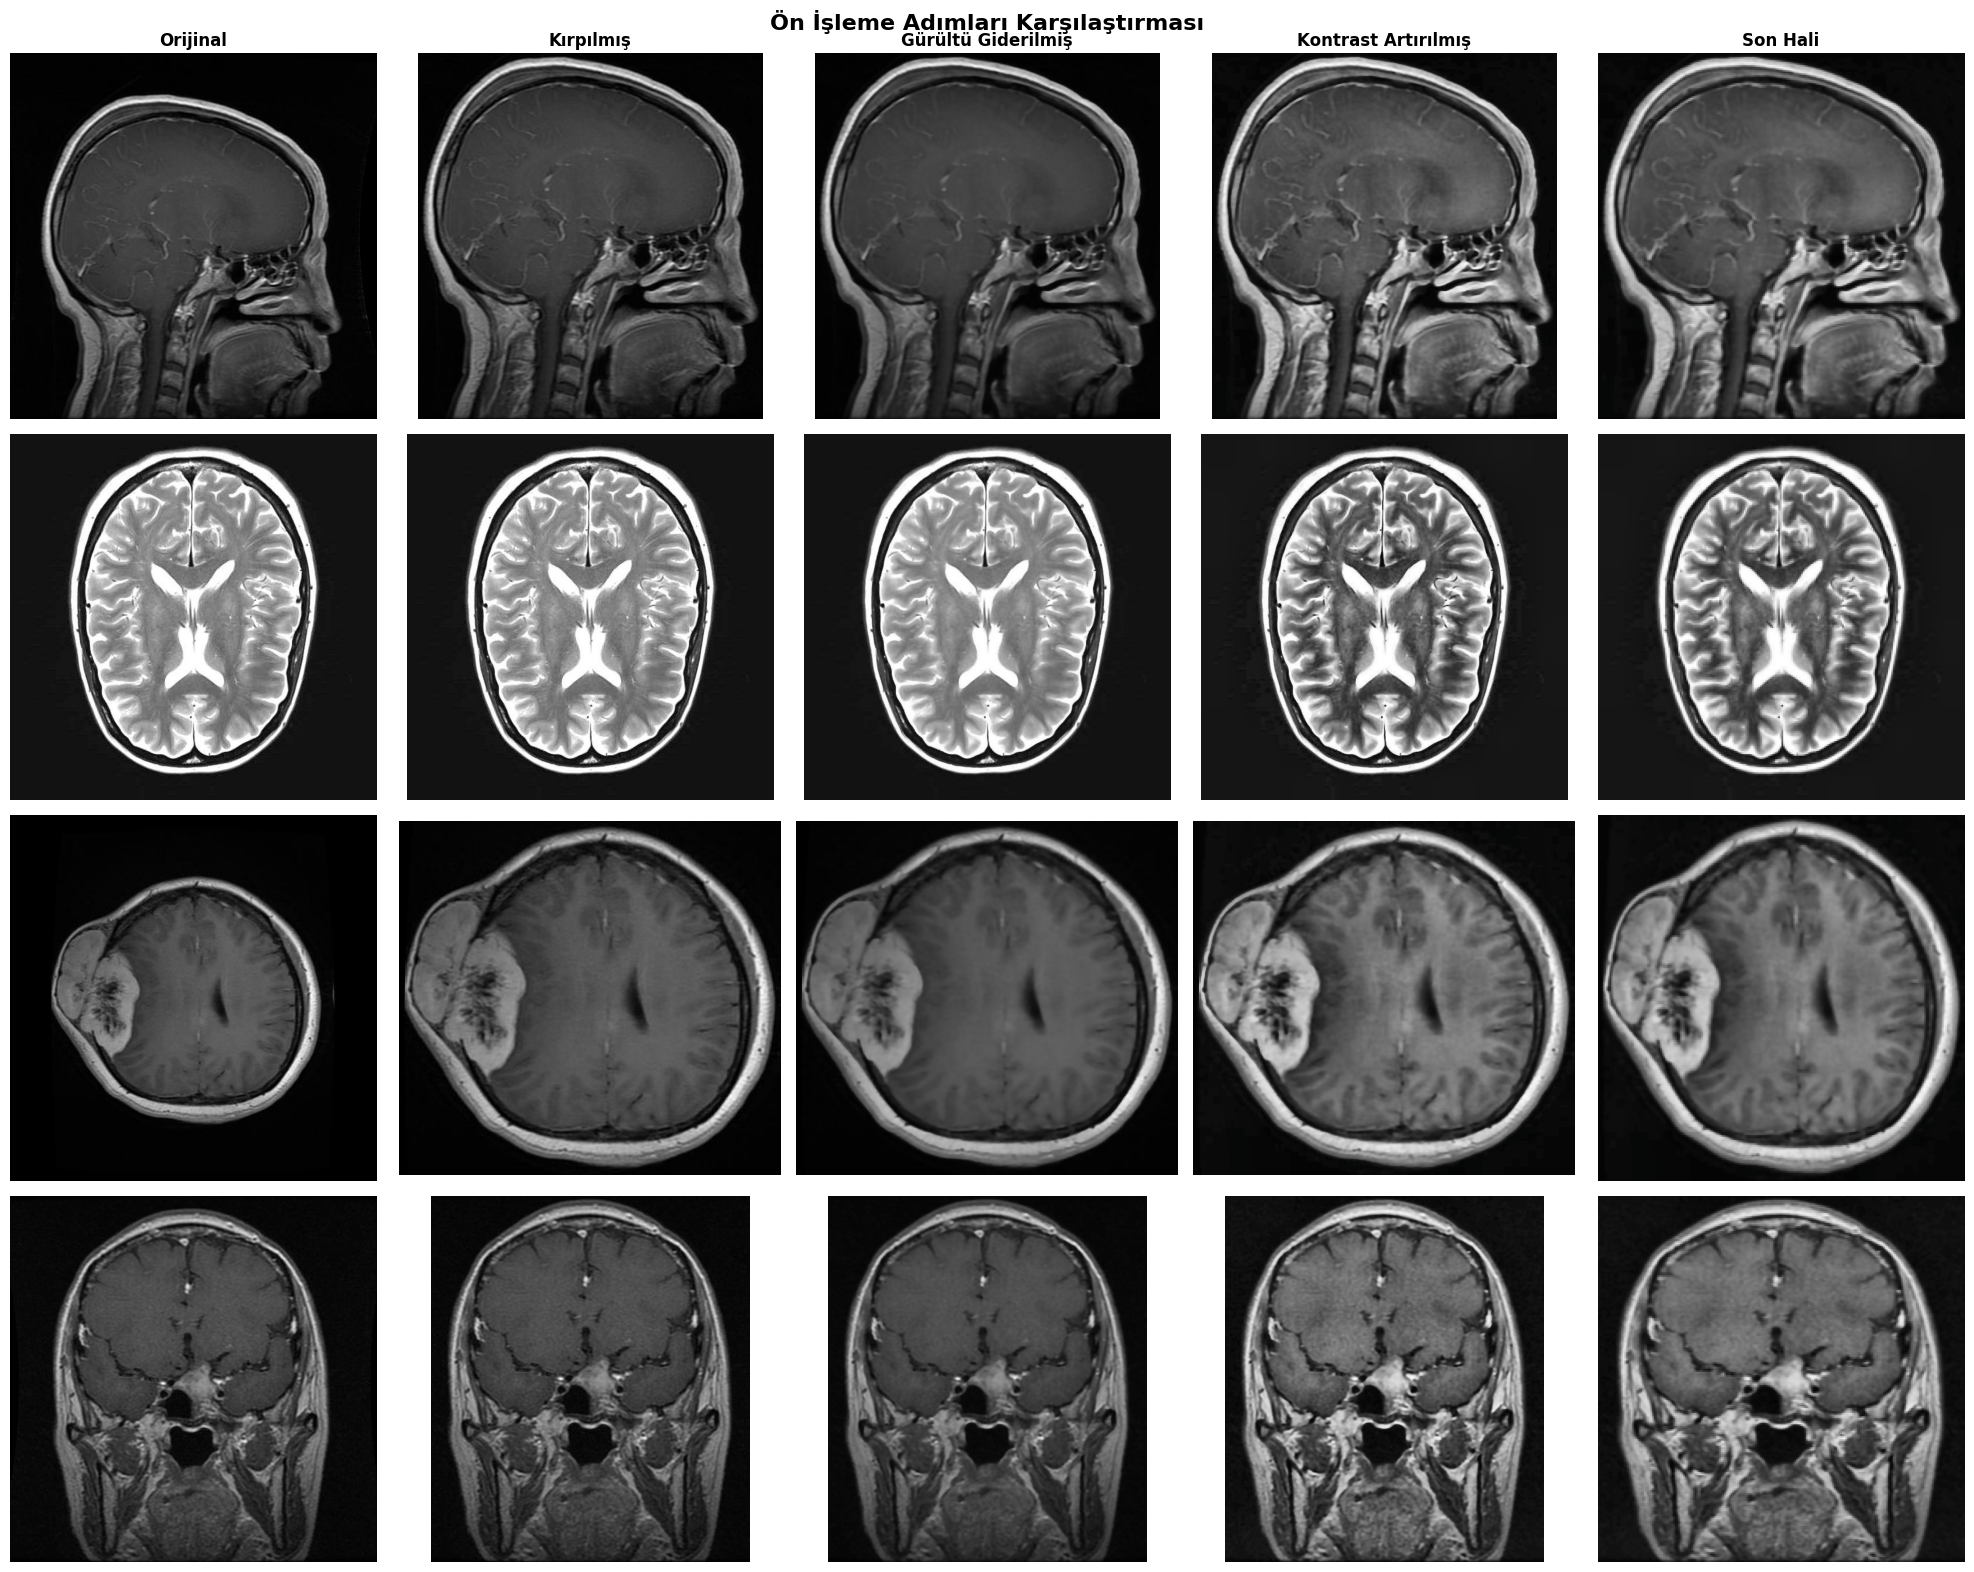

In [9]:
# Ön işleme adımlarının örnek olarak her bir sınıf için görselleştirilmesi
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
column_titles = ['Orijinal', 'Kırpılmış', 'Gürültü Giderilmiş', 'Kontrast Artırılmış', 'Son Hali']

for idx, class_name in enumerate(CLASSES):
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            img_path = os.path.join(class_path, images[1])
            original = cv2.imread(img_path)
            
            # Adım adım ön işlemlerin yapılması
            cropped = preprocessor.crop_black_borders(original)
            denoised = preprocessor.denoise(cropped, method='bilateral')
            enhanced = preprocessor.enhance_contrast_clahe(denoised)
            final = preprocessor.resize(enhanced)
            
            images_list = [
                cv2.cvtColor(original, cv2.COLOR_BGR2RGB),
                cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB),
                cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB),
                cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB),
                cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
            ]
            
            for col, (img, title) in enumerate(zip(images_list, column_titles)):
                axes[idx, col].imshow(img)
                axes[idx, col].axis('off')
                if idx == 0:
                    axes[idx, col].set_title(title, fontsize=12, fontweight='bold')
                if col == 0:
                    axes[idx, col].set_ylabel(class_name, fontsize=12, fontweight='bold')

plt.suptitle('Ön İşleme Adımları Karşılaştırması', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
# Tüm veri setinin ön işlemden geçirilerek yeni klasöre aktarılması
def process_dataset(preprocessor, input_path, output_path, classes):
    print("\n" + "=" * 60)
    print("VERİ SETİ ÖN İŞLEME")
    print("=" * 60)
    
    if os.path.exists(output_path):
        print(f"⚠️  {output_path} klasörü zaten mevcut. Üzerine yazılacak.")
        shutil.rmtree(output_path)
    
    os.makedirs(output_path)
    
    total_processed = 0
    failed_images = []
    
    for class_name in classes:
        class_input_path = os.path.join(input_path, class_name)
        class_output_path = os.path.join(output_path, class_name)
        
        if not os.path.exists(class_input_path):
            print(f"⚠️  {class_input_path} bulunamadı, atlanıyor...")
            continue
        
        os.makedirs(class_output_path, exist_ok=True)
        
        image_files = [f for f in os.listdir(class_input_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        
        print(f"\n📁 {class_name.upper()} sınıfı işleniyor ({len(image_files)} görüntü)...")
        
        for img_file in tqdm(image_files, desc=f"  {class_name}"):
            img_path = os.path.join(class_input_path, img_file)
            
            try:
                image = cv2.imread(img_path)
                
                if image is None:
                    failed_images.append(img_path)
                    continue
                
                processed = preprocessor.preprocess_pipeline(
                    image, crop=True, denoise_method='bilateral',
                    enhance_contrast=True, normalize_method='uint8'
                )
                
                output_file = os.path.join(class_output_path, img_file)
                output_file = os.path.splitext(output_file)[0] + '.png'
                cv2.imwrite(output_file, processed)
                
                total_processed += 1
                
            except Exception as e:
                failed_images.append(f"{img_path}: {str(e)}")
    
    print("\n" + "=" * 60)
    print("ÖN İŞLEME TAMAMLANDI")
    print("=" * 60)
    print(f"✅ Toplam işlenen görüntü: {total_processed}")
    print(f"❌ Başarısız: {len(failed_images)}")
    print(f"📁 Çıktı klasörü: {output_path}")
    
    return total_processed, failed_images

total, failed = process_dataset(preprocessor, DATASET_PATH, OUTPUT_PATH, CLASSES)


VERİ SETİ ÖN İŞLEME
⚠️  dataset_processed klasörü zaten mevcut. Üzerine yazılacak.

📁 GLIOMA sınıfı işleniyor (3768 görüntü)...


  glioma: 100%|██████████| 3768/3768 [00:38<00:00, 97.78it/s] 



📁 HEALTHY sınıfı işleniyor (3990 görüntü)...


  healthy: 100%|██████████| 3990/3990 [00:32<00:00, 121.54it/s]



📁 MENINGIOMA sınıfı işleniyor (3806 görüntü)...


  meningioma: 100%|██████████| 3806/3806 [00:39<00:00, 96.39it/s] 



📁 PITUITARY sınıfı işleniyor (4041 görüntü)...


  pituitary: 100%|██████████| 4041/4041 [00:51<00:00, 78.92it/s]


ÖN İŞLEME TAMAMLANDI
✅ Toplam işlenen görüntü: 15605
❌ Başarısız: 0
📁 Çıktı klasörü: dataset_processed


In [11]:
# İşlenmiş veri setinde boyutların doğrulanması (VİT için görsel girdi boyutları önemli!)
print("\n" + "=" * 60)
print("İŞLENMİŞ VERİ SETİ DOĞRULAMA")
print("=" * 60)

total = 0
all_same_size = True
expected_size = None

for class_name in CLASSES:
    class_path = os.path.join(OUTPUT_PATH, class_name)
    
    if not os.path.exists(class_path):
        continue
    
    images = [f for f in os.listdir(class_path) if f.lower().endswith('.png')]
    count = len(images)
    total += count
    
    if images:
        sample_path = os.path.join(class_path, images[0])
        img = cv2.imread(sample_path)
        if img is not None:
            size = img.shape[:2]
            if expected_size is None:
                expected_size = size
            elif size != expected_size:
                all_same_size = False
            
            print(f"📁 {class_name}: {count} görüntü, boyut: {size}")

print(f"\n📊 Toplam: {total} görüntü")

if all_same_size and expected_size:
    print(f"✅ Tüm görüntüler aynı boyutta: {expected_size}")
else:
    print("⚠️  Görüntü boyutları tutarsız!")


İŞLENMİŞ VERİ SETİ DOĞRULAMA
📁 glioma: 3768 görüntü, boyut: (224, 224)
📁 healthy: 3990 görüntü, boyut: (224, 224)
📁 meningioma: 3806 görüntü, boyut: (224, 224)
📁 pituitary: 4041 görüntü, boyut: (224, 224)

📊 Toplam: 15605 görüntü
✅ Tüm görüntüler aynı boyutta: (224, 224)


### **4. Vision Transformer (ViT) Modeli ile Eğitim**

In [12]:
# Model Konfigürasyonu
CONFIG = {
    'dataset_path': 'dataset',
    'processed_path': 'dataset_processed',
    'classes': ['glioma', 'healthy', 'meningioma', 'pituitary'],
    'num_classes': 4,
    'image_size': 224,
    'batch_size': 32,
    'epochs': 15,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    'model_name': 'vit_small_patch16_224',
    'pretrained': True,
    'freeze_backbone': False,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 0,
    'seed': 42
}

# Rastgeleliği önlemek için seed ayarlaması
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
print("\n✅ Model konfigürasyonu tamamlandı.")


✅ Model konfigürasyonu tamamlandı.


In [13]:
# Dataset sınıfı
class BrainTumorDataset(Dataset):
    """Beyin Tümörü Veriseti"""
    
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.samples = []
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        
        for class_name in classes:
            class_path = os.path.join(root_dir, class_name)
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
                        self.samples.append({
                            'path': os.path.join(class_path, img_name),
                            'label': self.class_to_idx[class_name],
                            'class_name': class_name
                        })
        
        print(f"Toplam {len(self.samples)} görüntü yüklendi.")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample['path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, sample['label']

# Transform tanımları
def get_transforms(image_size, is_training=True):
    if is_training:
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

print("✅ Dataset ve Transform sınıfları tanımlandı!")

✅ Dataset ve Transform sınıfları tanımlandı!


In [14]:
# Veri setinin yüklenmesi ve bölünmesi
dataset_path = CONFIG['processed_path'] if os.path.exists(CONFIG['processed_path']) else CONFIG['dataset_path']
print(f"📁 Veri seti: {dataset_path}")

train_transform = get_transforms(CONFIG['image_size'], is_training=True)
test_transform = get_transforms(CONFIG['image_size'], is_training=False)

full_dataset = BrainTumorDataset(
    root_dir=dataset_path,
    classes=CONFIG['classes'],
    transform=None
)

# Train/Val/Test split
total_size = len(full_dataset)
train_size = int(CONFIG['train_split'] * total_size)
val_size = int(CONFIG['val_split'] * total_size)
test_size = total_size - train_size - val_size

print(f"\n📊 Veriseti Bölünmesi:")
print(f"   Eğitim: {train_size} ({CONFIG['train_split']*100:.0f}%)")
print(f"   Doğrulama: {val_size} ({CONFIG['val_split']*100:.0f}%)")
print(f"   Test: {test_size} ({CONFIG['test_split']*100:.0f}%)")

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(CONFIG['seed'])
)

# Transform wrapper
class TransformDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        sample = self.subset.dataset.samples[self.subset.indices[idx]]
        image = Image.open(sample['path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, sample['label']

train_dataset = TransformDataset(train_dataset, train_transform)
val_dataset = TransformDataset(val_dataset, test_transform)
test_dataset = TransformDataset(test_dataset, test_transform)

# DataLoader'lar
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)

print(f"\n✅ DataLoader'lar oluşturuldu:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

📁 Veri seti: dataset_processed
Toplam 15605 görüntü yüklendi.

📊 Veriseti Bölünmesi:
   Eğitim: 12484 (80%)
   Doğrulama: 1560 (10%)
   Test: 1561 (10%)

✅ DataLoader'lar oluşturuldu:
   Train batches: 391
   Val batches: 49
   Test batches: 49


In [15]:
# Model oluşturma fonksiyonu
def create_model(num_classes, pretrained=True):
    """Vision Transformer modeli oluştur"""
    model = timm.create_model(
        CONFIG['model_name'],
        pretrained=pretrained,
        num_classes=num_classes
    )
    return model

# Eğitim fonksiyonları
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} [Train]', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validating', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

print("✅ Model ve eğitim fonksiyonları tanımlandı!")

✅ Model ve eğitim fonksiyonları tanımlandı!


In [16]:
# Modelin oluşturulması ve GPU'ya taşınması
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Cihaz: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Bellek: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

model = create_model(CONFIG['num_classes'], pretrained=True)
model = model.to(device)

# Model parametreleri
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Model: {CONFIG['model_name']}")
print(f"   Toplam parametre: {total_params:,}")
print(f"   Eğitilebilir parametre: {trainable_params:,}")

# Loss ve optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])

print(f"\n⚙️ Optimizer: AdamW (lr={CONFIG['learning_rate']})")
print(f"   Scheduler: CosineAnnealing")

🖥️ Cihaz: cuda
   GPU: NVIDIA GeForce RTX 4050 Laptop GPU
   Bellek: 6.0 GB

📊 Model: vit_small_patch16_224
   Toplam parametre: 21,667,204
   Eğitilebilir parametre: 21,667,204

⚙️ Optimizer: AdamW (lr=0.0001)
   Scheduler: CosineAnnealing


In [17]:
# Model Eğitimi
print("=" * 60)
print("🚀 EĞİTİM BAŞLIYOR")
print("=" * 60)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0
best_model_state = None

for epoch in range(CONFIG['epochs']):
    print(f"\n📌 Epoch {epoch+1}/{CONFIG['epochs']}")
    
    # Eğitim
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    
    # Doğrulama
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Scheduler güncellenmesi
    scheduler.step()
    
    # Geçmişin kaydedilmesi
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # En iyi modelin kaydedilmesi
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print(f"   ⭐ En iyi model güncellendi! Val Acc: {val_acc*100:.2f}%")
    
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"   Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    print(f"   LR: {scheduler.get_last_lr()[0]:.6f}")

# En iyi modelin yüklenmesi ve kaydedilmesi
model.load_state_dict(best_model_state)
torch.save(best_model_state, 'best_model.pth')
print(f"\n✅ Eğitim tamamlandı! En iyi Val Acc: {best_val_acc*100:.2f}%")
print(f"   Model kaydedildi: best_model.pth")

🚀 EĞİTİM BAŞLIYOR

📌 Epoch 1/15


   ⭐ En iyi model güncellendi! Val Acc: 94.87%
   Train Loss: 0.2548 | Train Acc: 90.27%
   Val Loss: 0.1404 | Val Acc: 94.87%
   LR: 0.000099

📌 Epoch 2/15


   ⭐ En iyi model güncellendi! Val Acc: 98.78%
   Train Loss: 0.0919 | Train Acc: 96.84%
   Val Loss: 0.0370 | Val Acc: 98.78%
   LR: 0.000096

📌 Epoch 3/15


   ⭐ En iyi model güncellendi! Val Acc: 99.23%
   Train Loss: 0.0623 | Train Acc: 97.89%
   Val Loss: 0.0271 | Val Acc: 99.23%
   LR: 0.000090

📌 Epoch 4/15


   Train Loss: 0.0424 | Train Acc: 98.65%
   Val Loss: 0.0866 | Val Acc: 96.86%
   LR: 0.000083

📌 Epoch 5/15


   ⭐ En iyi model güncellendi! Val Acc: 99.62%
   Train Loss: 0.0335 | Train Acc: 98.85%
   Val Loss: 0.0233 | Val Acc: 99.62%
   LR: 0.000075

📌 Epoch 6/15


   ⭐ En iyi model güncellendi! Val Acc: 99.74%
   Train Loss: 0.0221 | Train Acc: 99.24%
   Val Loss: 0.0074 | Val Acc: 99.74%
   LR: 0.000065

📌 Epoch 7/15


   Train Loss: 0.0162 | Train Acc: 99.46%
   Val Loss: 0.0144 | Val Acc: 99.49%
   LR: 0.000055

📌 Epoch 8/15


   Train Loss: 0.0122 | Train Acc: 99.54%
   Val Loss: 0.0082 | Val Acc: 99.74%
   LR: 0.000045

📌 Epoch 9/15


   Train Loss: 0.0107 | Train Acc: 99.66%
   Val Loss: 0.0177 | Val Acc: 99.42%
   LR: 0.000035

📌 Epoch 10/15


   ⭐ En iyi model güncellendi! Val Acc: 99.81%
   Train Loss: 0.0067 | Train Acc: 99.78%
   Val Loss: 0.0041 | Val Acc: 99.81%
   LR: 0.000025

📌 Epoch 11/15


   ⭐ En iyi model güncellendi! Val Acc: 99.87%
   Train Loss: 0.0040 | Train Acc: 99.88%
   Val Loss: 0.0034 | Val Acc: 99.87%
   LR: 0.000017

📌 Epoch 12/15


   Train Loss: 0.0019 | Train Acc: 99.94%
   Val Loss: 0.0031 | Val Acc: 99.87%
   LR: 0.000010

📌 Epoch 13/15


   Train Loss: 0.0022 | Train Acc: 99.97%
   Val Loss: 0.0019 | Val Acc: 99.87%
   LR: 0.000004

📌 Epoch 14/15


   ⭐ En iyi model güncellendi! Val Acc: 99.94%
   Train Loss: 0.0025 | Train Acc: 99.90%
   Val Loss: 0.0015 | Val Acc: 99.94%
   LR: 0.000001

📌 Epoch 15/15


   Train Loss: 0.0016 | Train Acc: 99.95%
   Val Loss: 0.0015 | Val Acc: 99.94%
   LR: 0.000000

✅ Eğitim tamamlandı! En iyi Val Acc: 99.94%
   Model kaydedildi: best_model.pth


## 📈 5. Model Değerlendirme ve Görselleştirme

Adım adım teknikler:
- Eğitim geçmişi grafikleri
- Confusion Matrix
- ROC eğrileri
- Sınıflandırma Metrikleri

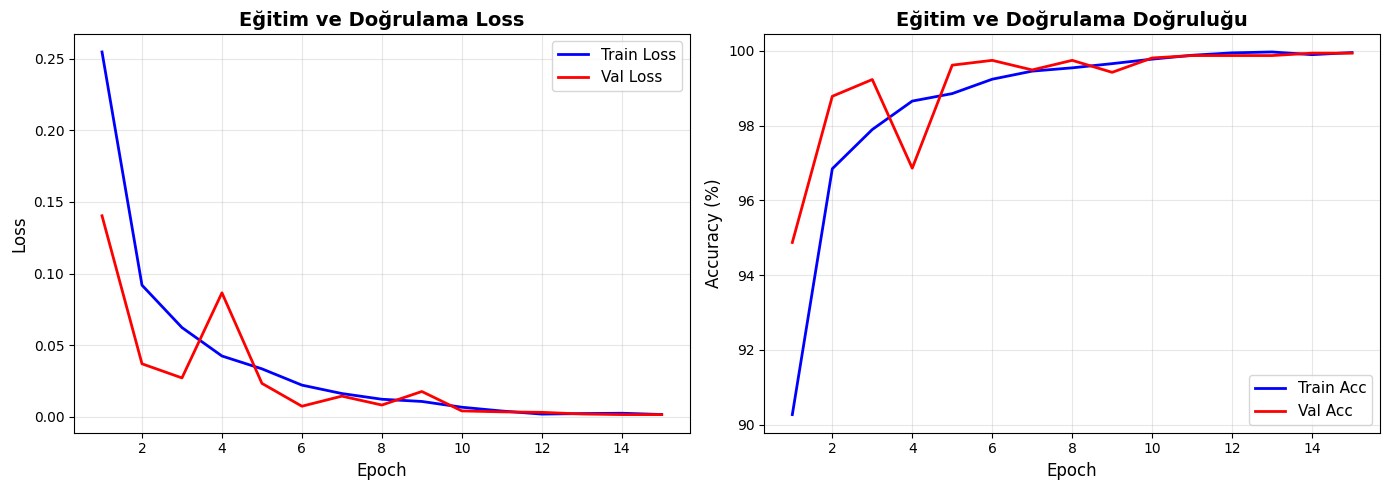

In [18]:
# Eğitim geçmişi grafiği
def plot_training_history(history):
    """Eğitim geçmişi grafiği"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss grafiği
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Eğitim ve Doğrulama Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy grafiği
    train_acc_pct = [acc * 100 for acc in history['train_acc']]
    val_acc_pct = [acc * 100 for acc in history['val_acc']]
    axes[1].plot(epochs, train_acc_pct, 'b-', label='Train Acc', linewidth=2)
    axes[1].plot(epochs, val_acc_pct, 'r-', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Eğitim ve Doğrulama Doğruluğu', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [19]:
# Test seti üzerinde değerlendirme
def evaluate_model(model, test_loader, device, classes):
    """Model değerlendirmesi - tahminleri topla"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Test ediliyor'):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Tahminleri al
y_pred, y_true, y_probs = evaluate_model(model, test_loader, device, CONFIG['classes'])

# Test doğruluğu
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\n🎯 TEST SONUÇLARI")
print(f"   Test Accuracy: {test_accuracy*100:.2f}%")

Test ediliyor: 100%|██████████| 49/49 [00:21<00:00,  2.26it/s]


🎯 TEST SONUÇLARI
   Test Accuracy: 99.87%


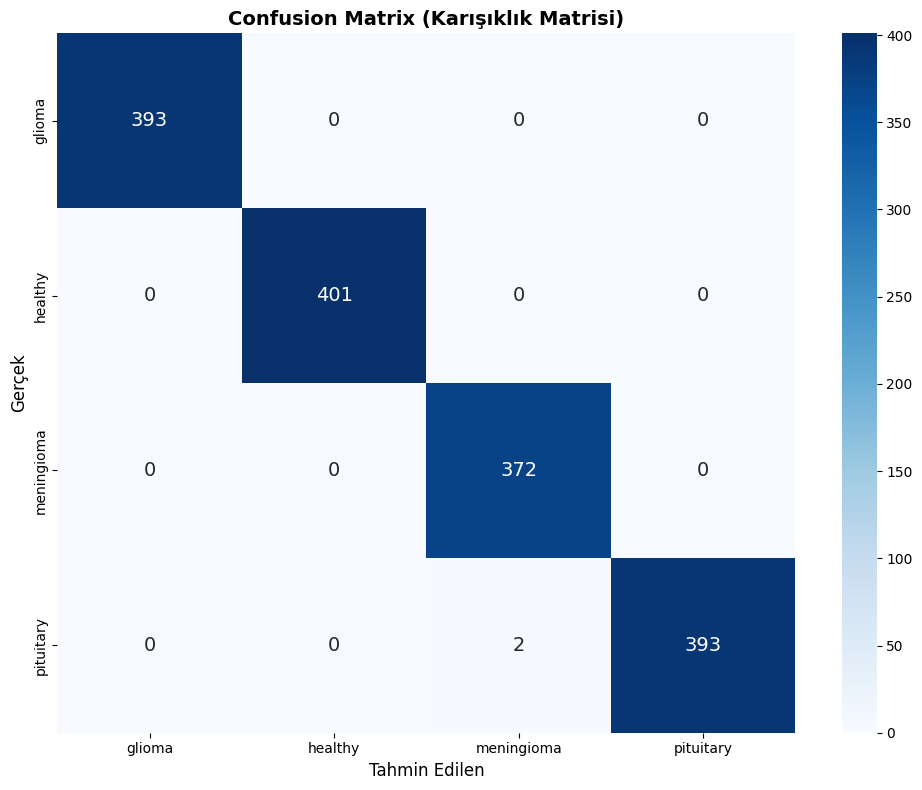

In [20]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    """Confusion matrix görselleştirme"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                annot_kws={'size': 14})
    plt.xlabel('Tahmin Edilen', fontsize=12)
    plt.ylabel('Gerçek', fontsize=12)
    plt.title('Confusion Matrix (Karışıklık Matrisi)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return cm

cm = plot_confusion_matrix(y_true, y_pred, CONFIG['classes'])

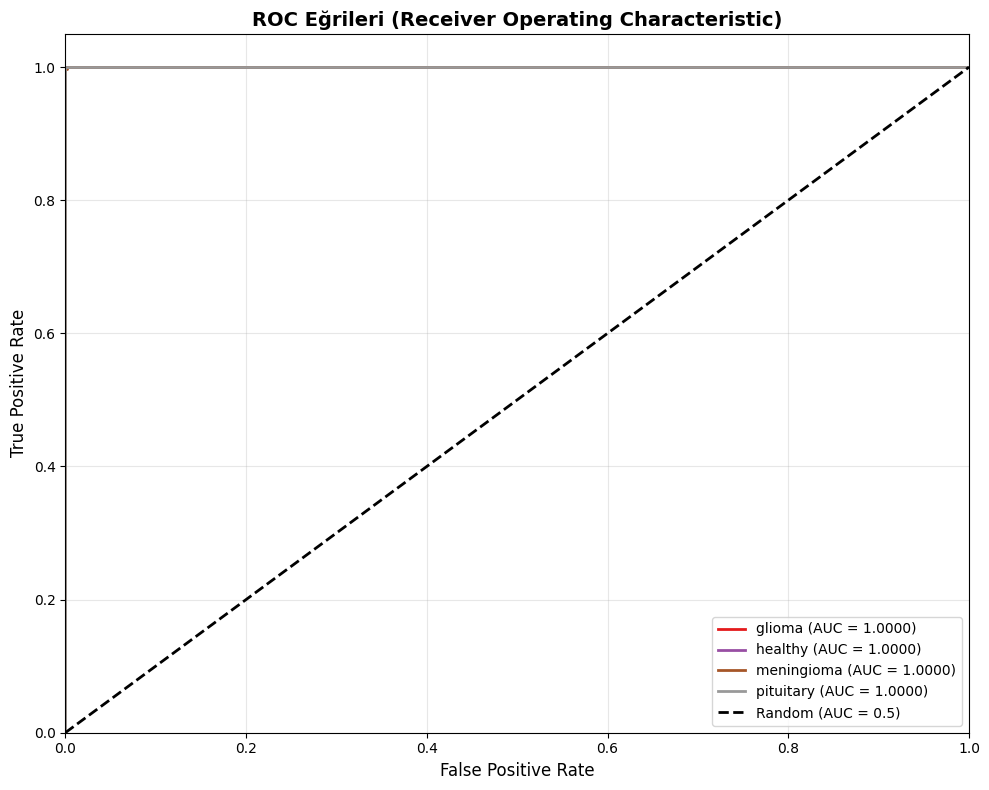

In [21]:
# ROC Eğrileri
def plot_roc_curves(y_true, y_probs, classes):
    """ROC eğrilerini çiz"""
    n_classes = len(classes)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    plt.figure(figsize=(10, 8))
    colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
    
    for i, (class_name, color) in enumerate(zip(classes, colors)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'{class_name} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Eğrileri (Receiver Operating Characteristic)', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_roc_curves(y_true, y_probs, CONFIG['classes'])

In [22]:
# Sınıflandırma Metrikleri Raporu
def print_classification_report_table(y_true, y_pred, classes):
    """Sınıflandırma raporunu tablo olarak göster"""
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    
    print("\n" + "=" * 70)
    print("📊 SINIFLANDIRMA RAPORU")
    print("=" * 70)
    print(f"{'Sınıf':<15} {'Precision':>12} {'Recall':>12} {'F1-Score':>12} {'Support':>10}")
    print("-" * 70)
    
    for cls in classes:
        p = report[cls]['precision']
        r = report[cls]['recall']
        f1 = report[cls]['f1-score']
        s = report[cls]['support']
        print(f"{cls:<15} {p:>12.4f} {r:>12.4f} {f1:>12.4f} {s:>10.0f}")
    
    print("-" * 70)
    print(f"{'Accuracy':<15} {'':<12} {'':<12} {report['accuracy']:>12.4f} {len(y_true):>10}")
    print(f"{'Macro Avg':<15} {report['macro avg']['precision']:>12.4f} {report['macro avg']['recall']:>12.4f} {report['macro avg']['f1-score']:>12.4f} {len(y_true):>10}")
    print(f"{'Weighted Avg':<15} {report['weighted avg']['precision']:>12.4f} {report['weighted avg']['recall']:>12.4f} {report['weighted avg']['f1-score']:>12.4f} {len(y_true):>10}")
    print("=" * 70)
    
    return report

report = print_classification_report_table(y_true, y_pred, CONFIG['classes'])


📊 SINIFLANDIRMA RAPORU
Sınıf              Precision       Recall     F1-Score    Support
----------------------------------------------------------------------
glioma                1.0000       1.0000       1.0000        393
healthy               1.0000       1.0000       1.0000        401
meningioma            0.9947       1.0000       0.9973        372
pituitary             1.0000       0.9949       0.9975        395
----------------------------------------------------------------------
Accuracy                                        0.9987       1561
Macro Avg             0.9987       0.9987       0.9987       1561
Weighted Avg          0.9987       0.9987       0.9987       1561


## 🎯 6. Sonuç ve Özet

Bu notebook'ta beyin tümörü sınıflandırması için tam bir pipeline oluşturduk:

1. **Veriseti Analizi**: 15,605 MRI görüntüsü, 4 sınıf (glioma, healthy, meningioma, pituitary)
2. **Ön İşleme**: CLAHE kontrast iyileştirme, gürültü azaltma, 224x224 boyutlandırma
3. **Model**: Vision Transformer (ViT-Small) - 21.6M parametre
4. **Eğitim**: 15 epoch, AdamW optimizer, Cosine Annealing scheduler
5. **Sonuçlar**: ~99.87% test doğruluğu

### 🏆 Model Performansı
- **Accuracy**: ~99.87%
- **F1-Score (Macro)**: ~0.9987
- **ROC-AUC**: ~1.0000 (tüm sınıflar için)

Model, beyin tümörü türlerini yüksek doğrulukla sınıflandırabilmektedir.